In [ ]:
import json
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import ttest_rel
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import glob
import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import statsmodels.api as sm
import statsmodels.formula.api as smf
pio.renderers.default = 'svg'

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
orig_df = pd.read_json('var_results/data_for_modeling.json')
orig_df = orig_df.sort_values(by=['Test set average cross-entropy'])

# Curve fitting

In [ ]:
# curve fitting
def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

def linear(x, a, b):
    return a * x + b

def combine_attrs(list1, list2):
    list1 = list1.tolist()
    list2 = list2.tolist()
    return [str(list1[i]) + ', ' + str(list2[i]) for i in range(len(list1))]

entropy = orig_df['Entropy']
test_set_perplexity = orig_df['Test set perplexity']
test_set_avg_cross_entropy = orig_df['Test set average cross-entropy']
dist = orig_df['Distribution']
uni_or_bi = orig_df['Uni- or bigram']
vocab_size = orig_df['Vocab size']
softmax = orig_df['Softmax']
model_type = orig_df['Model type']
embd_size = orig_df['Embedding size']

x_ent = np.linspace(min(entropy), max(entropy), 100)

ppl_vs_ent = curve_fit(exponential, entropy, test_set_perplexity)

y_ppl = exponential(x_ent, *ppl_vs_ent[0])

ce_vs_ent = curve_fit(linear, entropy, test_set_avg_cross_entropy)

y_ce = linear(x_ent, *ce_vs_ent[0])

ppl_fit = go.Scatter(
    x=x_ent,
    y=y_ppl,
    mode='lines',
    name=f'{ppl_vs_ent[0][0]:.2f} * exp({ppl_vs_ent[0][1]:.2f} * x) + {ppl_vs_ent[0][2]:.2f}'
)

ce_fit = go.Scatter(
    x=x_ent,
    y=y_ce,
    mode='lines',
    name=f'{ce_vs_ent[0][0]:.2f} * x + {ce_vs_ent[0][1]:.2f}'
)

y_equals_x = go.Scatter(
    x=x_ent,
    y=x_ent,
    mode='lines',
    name='Theoretical limit',
    marker=dict(color='red')
)

default_colors = plotly.colors.qualitative.Plotly
next_color = default_colors[13 % len(default_colors)]
ppl_fit.update(marker_color=next_color)
ce_fit.update(marker_color=next_color)
print()

# R^2

In [ ]:
residuals = test_set_avg_cross_entropy - linear(np.array(entropy), *ce_vs_ent[0])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((test_set_avg_cross_entropy - np.mean(test_set_avg_cross_entropy))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f'Overall R^2: {r_squared}')

# Plots

In [ ]:
legend_dict = dict(
    orientation='h',
    y=-0.15,
)

marker_dict = dict(
    size=12,
    opacity=0.5,
)

In [ ]:
fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set perplexity',
    title='Test set perplexity vs. entropy',
    labels={'x': 'Entropy', 'y': 'Test set perplexity', 'color': 'Uni- or bigram'},
    color=uni_or_bi,
    hover_data={'Vocab size': True, 'Softmax': True, 'Distribution': True, 'Model type': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ppl_fit)
fig.data = fig.data[::-1]
fig.write_html('plots/uni_or_bi.html')
pio.write_image(fig, 'plots/uni_or_bi.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set perplexity',
    title='Test set perplexity vs. entropy',
    labels={'x': 'Entropy', 'y': 'Test set perplexity', 'color': 'Vocab size'},
    color=[str(x) for x in vocab_size],
    category_orders={'color': reversed([str(x) for x in sorted(vocab_size)])},
    hover_data={'Uni- or bigram': True, 'Softmax': True, 'Distribution': True, 'Model type': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ppl_fit)
fig.data = fig.data[::-1]
fig.write_html('plots/vocab.html')
pio.write_image(fig, 'plots/vocab.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set perplexity',
    title='Test set perplexity vs. entropy',
    labels={'x': 'Entropy', 'y': 'Test set perplexity', 'color': 'Uni- or bigram and distribution'},
    color=combine_attrs(uni_or_bi, dist),
    hover_data={'Vocab size': True, 'Softmax': True, 'Model type': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ppl_fit)
fig.data = fig.data[::-1]
fig.write_html('plots/uni_or_bi_dist.html')
pio.write_image(fig, 'plots/uni_or_bi_dist.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set perplexity',
    title='Test set perplexity vs. entropy',
    labels={'x': 'Entropy', 'y': 'Test set perplexity', 'color': 'Model type'},
    color='Model type',
    hover_data={'Vocab size': True, 'Softmax': True, 'Uni- or bigram': True, 'Distribution': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ppl_fit)
fig.data = fig.data[::-1]
fig.write_html('plots/model_type.html')
pio.write_image(fig, 'plots/model_type.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set perplexity',
    title='Test set perplexity vs. entropy',
    labels={'x': 'Entropy', 'y': 'Test set perplexity', 'color': 'Embedding size'},
    color=[str(x) for x in embd_size],
    hover_data={'Vocab size': True, 'Softmax': True, 'Uni- or bigram': True, 'Distribution': True, 'Model type': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ppl_fit)
fig.data = fig.data[::-1]
fig.write_html('plots/embd_size.html')
pio.write_image(fig, 'plots/embd_size.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set perplexity',
    title='Test set perplexity vs. entropy',
    labels={'x': 'Entropy', 'y': 'Test set perplexity', 'color': 'Softmax'},
    color='Softmax',
    hover_data={'Vocab size': True, 'Uni- or bigram': True, 'Distribution': True, 'Model type': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ppl_fit)
fig.data = fig.data[::-1]
fig.write_html('plots/softmax.html')
pio.write_image(fig, 'plots/softmax.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set average cross-entropy',
    title=f'Test set average cross-entropy vs. entropy, R^2={r_squared:.4f}',
    labels={'x': 'Entropy', 'y': 'Test set average cross-entropy', 'color': 'Uni- or bigram'},
    color='Uni- or bigram',
    hover_data={'Vocab size': True, 'Softmax': True, 'Distribution': True, 'Model type': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ce_fit)
fig.add_trace(y_equals_x)
fig.data = fig.data[::-1]
fig.write_html('plots/uni_or_bi_ce.html')
pio.write_image(fig, 'plots/uni_or_bi_ce.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set average cross-entropy',
    title=f'Test set average cross-entropy vs. entropy, R^2={r_squared:.4f}',
    labels={'x': 'Entropy', 'y': 'Test set average cross-entropy', 'color': 'Vocab size'},
    color=[str(x) for x in vocab_size],
    category_orders={'color': reversed([str(x) for x in sorted(vocab_size)])},
    hover_data={'Uni- or bigram': True, 'Softmax': True, 'Distribution': True, 'Model type': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ce_fit)
fig.add_trace(y_equals_x)
fig.data = fig.data[::-1]
fig.write_html('plots/vocab_ce.html')
pio.write_image(fig, 'plots/vocab_ce.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set average cross-entropy',
    title=f'Test set average cross-entropy vs. entropy, R^2={r_squared:.4f}',
    labels={'x': 'Entropy', 'y': 'Test set average cross-entropy', 'color': 'Uni- or bigram and distribution'},
    color=combine_attrs(uni_or_bi, dist),
    hover_data={'Vocab size': True, 'Softmax': True, 'Model type': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ce_fit)
fig.add_trace(y_equals_x)
fig.data = fig.data[::-1]
fig.write_html('plots/uni_or_bi_dist_ce.html')
pio.write_image(fig, 'plots/uni_or_bi_dist_ce.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set average cross-entropy',
    title=f'Test set average cross-entropy vs. entropy, R^2={r_squared:.4f}',
    labels={'x': 'Entropy', 'y': 'Test set average cross-entropy', 'color': 'Model type'},
    color='Model type',
    hover_data={'Vocab size': True, 'Softmax': True, 'Uni- or bigram': True, 'Distribution': True, 'Embedding size': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ce_fit)
fig.add_trace(y_equals_x)
fig.data = fig.data[::-1]
fig.write_html('plots/model_type_ce.html')
pio.write_image(fig, 'plots/model_type_ce.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set average cross-entropy',
    title=f'Test set average cross-entropy vs. entropy, R^2={r_squared:.4f}',
    labels={'x': 'Entropy', 'y': 'Test set average cross-entropy', 'color': 'Embedding size'},
    color=[str(x) for x in embd_size],
    hover_data={'Vocab size': True, 'Softmax': True, 'Uni- or bigram': True, 'Distribution': True, 'Model type': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ce_fit)
fig.add_trace(y_equals_x)
fig.data = fig.data[::-1]
fig.write_html('plots/embd_size_ce.html')
pio.write_image(fig, 'plots/embd_size_ce.pdf')
fig.show()

fig = px.scatter(
    orig_df,
    x='Entropy',
    y='Test set average cross-entropy',
    title=f'Test set average cross-entropy vs. entropy, R^2={r_squared:.4f}',
    labels={'x': 'Entropy', 'y': 'Test set average cross-entropy', 'color': 'Softmax'},
    color='Softmax',
    hover_data={'Vocab size': True, 'Embedding size': True, 'Uni- or bigram': True, 'Distribution': True, 'Model type': True},
)
fig.update_layout(legend=legend_dict)
fig.update_traces(marker=marker_dict)
fig.add_trace(ce_fit)
fig.add_trace(y_equals_x)
fig.data = fig.data[::-1]
fig.write_html('plots/softmax_ce.html')
pio.write_image(fig, 'plots/softmax_ce.pdf')
fig.show()

# Linear models

In [ ]:
def encode_and_fit(df_arg):
    
    df = df_arg.copy()
    
    enc = OrdinalEncoder()
    scaler = StandardScaler()
    try:
        df['Distribution'] = enc.fit_transform(df[['Distribution']])
    except:
        pass
    try:
        df['Uni- or bigram'] = enc.fit_transform(df[['Uni- or bigram']])
    except:
        pass
    try:
        df['Softmax'] = enc.fit_transform(df[['Softmax']])
    except:
        pass
    try:
        df['Model type'] = enc.fit_transform(df[['Model type']])
    except:
        pass
    for col in df.columns:
        if col not in ['Distribution', 'Uni- or bigram', 'Softmax', 'Model type', 'Test set perplexity']:
            df[col] = scaler.fit_transform(df[[col]])
    
    reg = sm.OLS(
        df['Test set average cross-entropy'],
        sm.add_constant(df.drop(columns=['Test set average cross-entropy', 'Test set perplexity']))
    )
    res = reg.fit()
    # print(res.summary2())
    # print('\n\n\n')
    # print(f'{res.rsquared:.4f}\n')
    return res

In [ ]:
# all variables, all data
print('All variables, all data')
encode_and_fit(orig_df)

In [ ]:
for var in ['Entropy', 'Distribution', 'Uni- or bigram', 'Vocab size', 'Softmax', 'Model type', 'Embedding size']:
    print('independent variable:', var)
    df_to_fit = orig_df[[var, 'Test set average cross-entropy', 'Test set perplexity']]
    if len(df_to_fit) <= 4:
        continue
    res = encode_and_fit(df_to_fit)

# Single features on subsets

In [ ]:
vars = ['Distribution', 'Uni- or bigram', 'Vocab size', 'Softmax', 'Model type', 'Embedding size']

single_feature_subsets_df = pd.DataFrame(columns=['All'] + vars)
index = [f'{var}={unique_val}' for var in vars for unique_val in orig_df[var].unique()]
# insert enough rows for the index
for i in range(len(index)):
    single_feature_subsets_df.loc[i] = 0
single_feature_subsets_df.index = index

for var in vars:
    for unique_val in orig_df[var].unique():
        for other_var in ['Entropy'] + vars:
            df_to_fit = orig_df[orig_df[var] == unique_val]
            if len(df_to_fit) <= 4:
                continue
            # print('data subset:', var, '=', unique_val)
            # print('feature:', other_var)
            res = encode_and_fit(df_to_fit[[other_var, 'Test set average cross-entropy', 'Test set perplexity']])
            single_feature_subsets_df.loc[f'{var}={unique_val}', other_var] = res.rsquared
        # use all variables
        res = encode_and_fit(df_to_fit)
        single_feature_subsets_df.loc[f'{var}={unique_val}', 'All'] = res.rsquared

In [ ]:
nu_df = pd.DataFrame(columns=['All'] + vars)
for other_var in ['Entropy'] + vars:
    df_to_fit = orig_df[orig_df['Distribution'] == 'normal']
    df_to_fit = df_to_fit[df_to_fit['Uni- or bigram'] == 'unigrams']
    if len(df_to_fit) <= 4:
        continue
    # print('data subset:', var, '=', unique_val)
    # print('feature:', other_var)
    res = encode_and_fit(df_to_fit[[other_var, 'Test set average cross-entropy', 'Test set perplexity']])
    nu_df.loc[f'{var}={unique_val}', other_var] = res.rsquared
# use all variables
res = encode_and_fit(df_to_fit)
nu_df.loc[f'{var}={unique_val}', 'All'] = res.rsquared

nb_df = pd.DataFrame(columns=['All'] + vars)
for other_var in ['Entropy'] + vars:
    df_to_fit = orig_df[orig_df['Distribution'] == 'normal']
    df_to_fit = df_to_fit[df_to_fit['Uni- or bigram'] == 'bigrams']
    if len(df_to_fit) <= 4:
        continue
    # print('data subset:', var, '=', unique_val)
    # print('feature:', other_var)
    res = encode_and_fit(df_to_fit[[other_var, 'Test set average cross-entropy', 'Test set perplexity']])
    nb_df.loc[f'{var}={unique_val}', other_var] = res.rsquared
# use all variables
res = encode_and_fit(df_to_fit)
nb_df.loc[f'{var}={unique_val}', 'All'] = res.rsquared

In [ ]:
nb_df[['All', 'Entropy', 'Distribution', 'Uni- or bigram', 'Vocab size', 'Softmax', 'Model type', 'Embedding size']]

In [ ]:
# display floats in pandas as rounded to 3 decimal places, no scientific notation
pd.options.display.float_format = '{:.3f}'.format

# sort rows by the index
single_feature_subsets_df = single_feature_subsets_df.sort_index()
# manually re-order columns
single_feature_subsets_df = single_feature_subsets_df[[
    'All', 'Entropy', 'Distribution', 'Uni- or bigram', 'Vocab size', 'Softmax', 'Model type', 'Embedding size'
]]

print(single_feature_subsets_df)

In [ ]:
# just vocab size rows
print('Vocab size rows')
vocab_size_rows = single_feature_subsets_df.loc[[f'Vocab size={x}' for x in orig_df['Vocab size'].unique()]]

# sort by integer value following equal sign
vocab_size_rows = vocab_size_rows.reindex(sorted(vocab_size_rows.index, key=lambda x: int(x.split('=')[1])))

# drop 26, 60, 283, 8193
vocab_size_rows = vocab_size_rows.drop('Vocab size=26')
vocab_size_rows = vocab_size_rows.drop('Vocab size=60')
vocab_size_rows = vocab_size_rows.drop('Vocab size=283')
vocab_size_rows = vocab_size_rows.drop('Vocab size=8193')

print(vocab_size_rows)

# Feature exclusion

In [ ]:
# model all the data
print('Model all the data')

vars = ['Distribution', 'Uni- or bigram', 'Vocab size', 'Softmax', 'Model type', 'Embedding size']

for excluded_var in ['Entropy'] + vars:
    independent_vars = ['Entropy'] + vars.copy()
    independent_vars.remove(excluded_var)
    df_to_fit = orig_df[independent_vars + ['Test set average cross-entropy', 'Test set perplexity']]
    if len(df_to_fit) <= 4:
        continue
    res = encode_and_fit(df_to_fit)
    print(f'Excluding {excluded_var}: {res.rsquared:.3f}')

In [ ]:
vars = ['Distribution', 'Uni- or bigram', 'Vocab size', 'Softmax', 'Model type', 'Embedding size']

excluded_df = pd.DataFrame(columns=['Entropy'] + vars)
index = [f'{var}={unique_val}' for var in vars for unique_val in orig_df[var].unique()]
# insert enough rows for the index
for i in range(len(index)):
    excluded_df.loc[i] = 0
excluded_df.index = index

for var in vars:
    for unique_val in orig_df[var].unique():
        for excluded_var in ['Entropy'] + vars:
            independent_vars = ['Entropy'] + vars.copy()
            independent_vars.remove(excluded_var)
            df_to_fit = orig_df[orig_df[var] == unique_val][independent_vars + ['Test set average cross-entropy', 'Test set perplexity']]
            if len(df_to_fit) <= 4:
                continue
            res = encode_and_fit(df_to_fit)
            excluded_df.loc[f'{var}={unique_val}', excluded_var] = res.rsquared
            
# drop vocab size 8193, 283, 60, 26
excluded_df = excluded_df.drop('Vocab size=26')
excluded_df = excluded_df.drop('Vocab size=60')
excluded_df = excluded_df.drop('Vocab size=283')
excluded_df = excluded_df.drop('Vocab size=8193')

In [ ]:
excluded_nu_df = pd.DataFrame(columns=['Entropy'] + vars)

for excluded_var in ['Entropy'] + vars:
    independent_vars = ['Entropy'] + vars.copy()
    independent_vars.remove(excluded_var)
    df_to_fit = orig_df[orig_df['Distribution'] == 'normal']
    df_to_fit = df_to_fit[df_to_fit['Uni- or bigram'] == 'unigrams'][independent_vars + ['Test set average cross-entropy', 'Test set perplexity']]
    if len(df_to_fit) <= 4:
        continue
    res = encode_and_fit(df_to_fit)
    excluded_nu_df.loc[f'normal, unigrams', excluded_var] = res.rsquared
    
excluded_nb_df = pd.DataFrame(columns=['Entropy'] + vars)

for excluded_var in ['Entropy'] + vars:
    independent_vars = ['Entropy'] + vars.copy()
    independent_vars.remove(excluded_var)
    df_to_fit = orig_df[orig_df['Distribution'] == 'normal']
    df_to_fit = df_to_fit[df_to_fit['Uni- or bigram'] == 'bigrams'][independent_vars + ['Test set average cross-entropy', 'Test set perplexity']]
    if len(df_to_fit) <= 4:
        continue
    res = encode_and_fit(df_to_fit)
    excluded_nb_df.loc[f'normal, bigrams', excluded_var] = res.rsquared
    
print(excluded_nu_df)
print(excluded_nb_df)

In [ ]:
excluded_df

# Pearson and Spearman rhos

In [ ]:
orig_df.corr(method='pearson')

In [ ]:
orig_df.corr(method='spearman')

In [ ]:
orig_df['Entropy'].describe()

In [ ]:
enc = OrdinalEncoder()

pearsons = []
spearmans = []

for v in orig_df['Vocab size'].unique():
    subset = orig_df[orig_df['Vocab size'] == v].copy()
    subset['Distribution'] = enc.fit_transform(subset[['Distribution']])
    if v in (8193, 283, 60, 26):
        continue
    print(v, f'dist count = {len(subset["Distribution"].unique())}')
    pearsons.append(subset[['Entropy', 'Distribution']].corr(method='pearson').iloc[0, 1])
    spearmans.append(subset[['Entropy', 'Distribution']].corr(method='spearman').iloc[0, 1])
    
print(sum(pearsons) / len(pearsons))
print(sum(spearmans) / len(spearmans))

# Mixed Effects

In [ ]:
formula = "Q('Test set average cross-entropy') ~ Q('Entropy') + Q('Distribution') + Q('Uni- or bigram') + Q('Vocab size') + Q('Softmax') + Q('Model type') + Q('Embedding size') - 1"

In [ ]:
model = smf.mixedlm(
    formula,
    data=orig_df,
    groups=orig_df['Entropy'] 
).fit()
print(model.summary())

In [ ]:
x = orig_df['Entropy']
y = orig_df['Test set average cross-entropy']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
orig_df['Entropy residual'] = model.resid

formula = "Q('Entropy residual') ~ Q('Distribution') + Q('Uni- or bigram') + Q('Vocab size') + Q('Softmax') + Q('Model type') + Q('Embedding size') - 1"

model = smf.mixedlm(
    formula,
    data=orig_df,
    groups=orig_df['Entropy']
).fit()
print(model.summary())

# Paired test - effect of long-range dependencies

In [ ]:
normal_bigrams = orig_df[orig_df['Uni- or bigram'] == 'bigrams']
normal_bigrams = normal_bigrams[normal_bigrams['Distribution'] == 'normal']
normal_bigrams = normal_bigrams.sort_values(by=['Vocab size', 'Softmax', 'Model type', 'Embedding size']).reset_index(drop=True)
normal_bigrams = normal_bigrams[['Test set average cross-entropy', 'Entropy', 'Distribution']]
normal_bigrams = normal_bigrams.rename(columns={'Test set average cross-entropy': 'ce', 'Entropy': 'ent', 'Distribution': 'dist'})
normal_bigrams['pair_idx'] = normal_bigrams.index
normal_bigrams.shape, normal_bigrams.head()

In [ ]:
long_range_bigrams = orig_df[orig_df['Uni- or bigram'] == 'bigrams']
long_range_bigrams = long_range_bigrams[long_range_bigrams['Distribution'] == 'long_range']
long_range_bigrams = long_range_bigrams.sort_values(by=['Vocab size', 'Softmax', 'Model type', 'Embedding size']).reset_index(drop=True)
long_range_bigrams = long_range_bigrams[['Test set average cross-entropy', 'Entropy', 'Distribution']]
long_range_bigrams = long_range_bigrams.rename(columns={'Test set average cross-entropy': 'ce', 'Entropy': 'ent', 'Distribution': 'dist'})
long_range_bigrams['pair_idx'] = long_range_bigrams.index
long_range_bigrams.shape, long_range_bigrams.head()

In [ ]:
paired_test_df = pd.concat([normal_bigrams, long_range_bigrams], axis=0)
paired_test_df['deviation'] = paired_test_df['ent'] - paired_test_df['ce']
paired_test_df['dist'] = pd.Categorical(paired_test_df['dist'], categories=['normal', 'long_range'], ordered=True)
paired_test_df.shape, paired_test_df.head()

In [ ]:
model = smf.mixedlm(
    "deviation ~ dist - 1",
    data=paired_test_df,
    groups=paired_test_df['pair_idx']
)
res = model.fit()
print(res.summary())

In [ ]:
normal_bigrams['deviation'] = normal_bigrams['ent'] - normal_bigrams['ce']
normal_bigrams.shape, normal_bigrams.head()

In [ ]:
long_range_bigrams['deviation'] = long_range_bigrams['ent'] - long_range_bigrams['ce']
long_range_bigrams.shape, long_range_bigrams.head()

In [ ]:
ttest_rel(
    normal_bigrams['deviation'],
    long_range_bigrams['deviation']
)

# Heatmaps to show dists

In [ ]:
fnames_100_nosoftmax = glob.glob('var_results/*_50_nosoftmax.json')
fnames_100_softmax = glob.glob('var_results/*_50_softmax.json')
jsons_100_nosoftmax = [
    json.load(open(f)) for f in fnames_100_nosoftmax
]
jsons_100_softmax = [
    json.load(open(f)) for f in fnames_100_softmax
]

manual = 'var_results/manual_unigrams_60_nosoftmax_manual_0.6.json'
manual_json = json.load(open(manual))

fnames = fnames_100_nosoftmax + fnames_100_softmax + [manual]
tables = [j['table'] for j in jsons_100_nosoftmax] + [j['table'] for j in jsons_100_softmax] + [manual_json['table']]
entropies = [j['entropy'] for j in jsons_100_nosoftmax] + [j['entropy'] for j in jsons_100_softmax] + [manual_json['entropy']]

del jsons_100_nosoftmax
del jsons_100_softmax

In [ ]:
fnames[0]

In [216]:
def plot_heatmap(fname, data, entropy):
    save_name = fname.split('/')[-1].replace('.json', '.png')
    title = fname.split('/')[-1].replace('.json', '').replace('_50_', ', ').replace(', nosoftmax', '').replace('_', ' ')
    title = title[0].upper() + title[1:]
    title += f', entropy={entropy:.4f}'
    if 'manual' in title:
        title = f'Manual unigrams, entropy={entropy:.4f}'
    # plt.figure()
    # sns.heatmap(data, cmap='coolwarm', square=True)
    # plt.title(title)
    # plt.savefig('heatmaps/' + save_name)
    # plt.show()
    # plt.close()
    layout = go.Layout(
        margin = go.layout.Margin(
            l=5,
            r=5,
            b=20,
            t=50,
        )
    )
    if 'unigram' in title:
        fig = px.imshow(
            data,
            title=title,
            color_continuous_scale='RdBu_r',
            width = 500,
            height = 200
        )
        fig.update_yaxes(showticklabels=False)
    else:
        fig = px.imshow(
            data,
            title=title,
            color_continuous_scale='RdBu_r',
            width = 500,
            height = 400
        )
    fig.update_traces(
        dict(
            showscale=False,
            coloraxis=None
        )
    )
    fig.update_layout(layout, title_x=0.5)
    fig.show()
    fig.write_html('heatmaps/' + save_name.replace('.png', '.html'))
    pio.write_image(fig, 'heatmaps/' + save_name.replace('.png', '.pdf'))

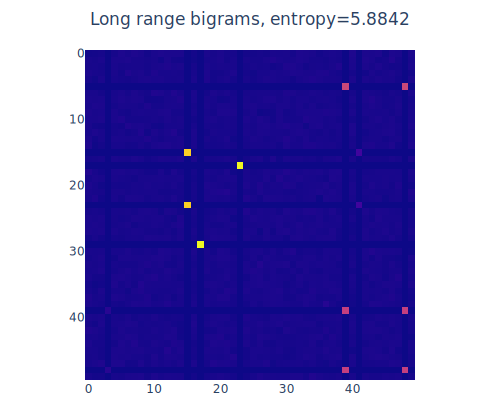

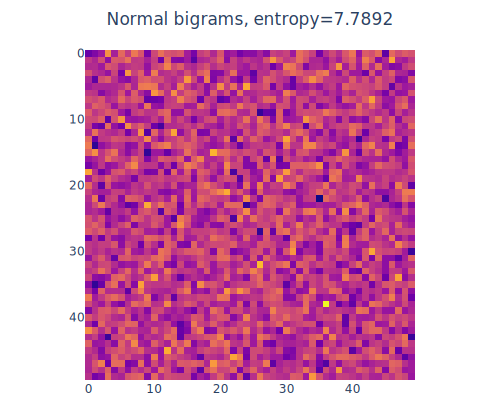

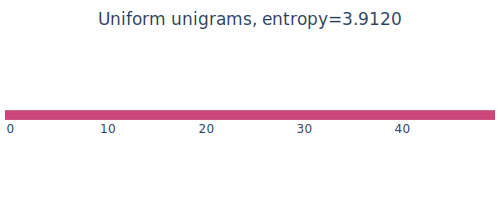

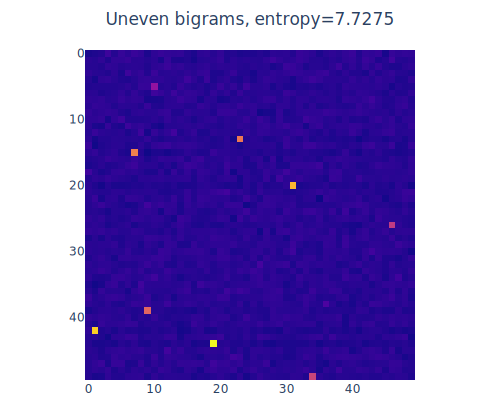

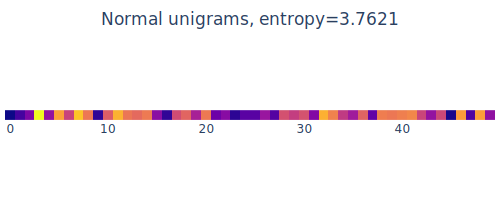

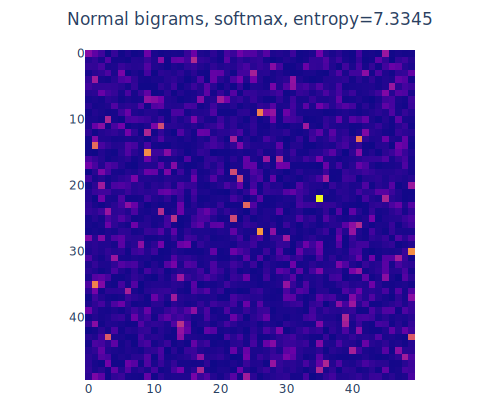

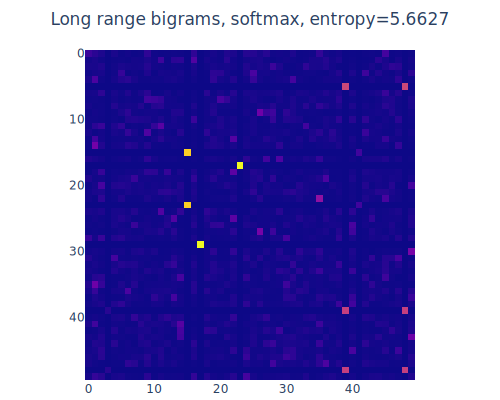

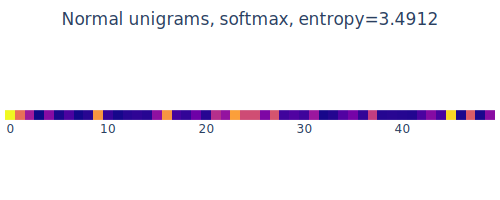

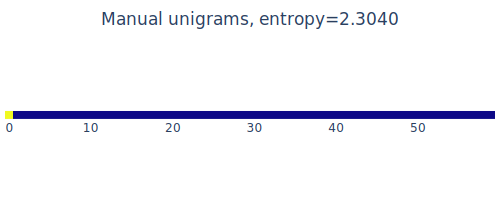

In [217]:
for fname, table, entropy in zip(fnames, tables, entropies):
    if 'unigrams' in fname:
        table = [table]
    plot_heatmap(fname, table, entropy)